# **Importing Data & Relevant Packages**



In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.utils import shuffle
import statsmodels.stats.proportion as prop
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
!pip install dowhy
import dowhy
from dowhy import CausalModel
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Note: The file path differs depending on where the dataset is located in your individual Drive. Please comment in the correct line and comment out the incorrect line depending on where you've stored the file.

df = pd.read_excel("/content/drive/MyDrive/BA472 Group 9 Project/Group9_Streaming2023.xlsx", sheet_name = "Rewards Program")
#df = pd.read_excel("/content/drive/My Drive/Colab Data/Group9_Streaming2023.xlsx", sheet_name = "Rewards Program")

df.head()

,Date,MonthlySubscriptionCost,SubscriptionType,DurationOfFreeTrial,HoursStreamed,UserSatisfactionScore,Customer ID,CustomerMaritalStatus,CustomerGender,CustomerAge,Shops Online or Not,Annual Income,RenewAfterTrial
0,2021-05-29,9.99,Premium,14,70,5.000000,1,Single,Female,20,Yes,96,Yes
1,2020-08-19,9.99,Premium,14,28,5.000000,2,Married,Other,51,No,146,Yes
2,2019-10-07,9.99,Premium,12,48,5.000000,3,Prefer not to answer,Other,27,Yes,62,Yes
3,2020-10-29,11.99,PremiumNoAds,12,36,3.226340,4,Prefer not to answer,Prefer not to answer,41,Yes,145,No
4,2020-06-11,11.99,PremiumNoAds,7,14,4.382243,5,Married,Prefer not to answer,48,No,193,No


In [ ]:
# Shape of the dataset
df.shape

(933, 13)

# **Data Cleaning**

In [ ]:
# Remove columns 'Date' and 'Customer ID', drop rows with missing values, and rename certain columns
df = df.drop(['Date', 'Customer ID'], axis = 1)
df = df.dropna(axis = 0)
df.rename(columns = {'RenewAfterTrial':'Subscribed', 'Shops Online or Not':'OnlineShopper', 'Annual Income':'AnnualIncome'}, inplace=True)
columns = ['MonthlySubscriptionCost', 'SubscriptionType', 'DurationOfFreeTrial', 'HoursStreamed', 'UserSatisfactionScore',
           'CustomerMaritalStatus', 'CustomerGender', 'CustomerAge', 'OnlineShopper', 'AnnualIncome', 'Subscribed']

for col in columns:
  df = df[df[col] != "-"]

In [ ]:
# Hotcoding binary variables into numerical representations
df['OnlineShopper'] = df['OnlineShopper'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Subscribed'] = df['Subscribed'].apply(lambda x: 1 if x == 'Yes' else 0)
df['AnnualIncome'] = pd.to_numeric(df['AnnualIncome'], errors='coerce').astype('int64')
df['SubscriptionTypeBinary'] = df['SubscriptionType'].apply(lambda x: 1 if x == 'PremiumNoAds' else 0)
df['CustomerMaritalStatus'] = df['CustomerMaritalStatus'].apply(lambda x: 1 if x == 'Married' or x== 'With a partner' else 0)
df['MonthlySubscriptionCost'] = pd.to_numeric(df['MonthlySubscriptionCost'], errors='coerce')
df['HoursStreamed'] = pd.to_numeric(df['HoursStreamed'], errors='coerce')
dummy_df = pd.get_dummies(df['CustomerGender'], prefix='CustomerGender')
df = pd.concat([df, dummy_df], axis=1)
df['AnnualIncomeBlocked'] = df['AnnualIncome'].apply(lambda x: 1 if x > 130 else 0)

In [ ]:
df.head()

,MonthlySubscriptionCost,SubscriptionType,DurationOfFreeTrial,HoursStreamed,UserSatisfactionScore,CustomerMaritalStatus,CustomerGender,CustomerAge,OnlineShopper,AnnualIncome,Subscribed,SubscriptionTypeBinary,CustomerGender_Female,CustomerGender_Male,CustomerGender_Non-binary,CustomerGender_Other,CustomerGender_Prefer not to answer,AnnualIncomeBlocked
0,9.99,Premium,14,70,5.000000,0,Female,20,1,96,1,0,1,0,0,0,0,0
1,9.99,Premium,14,28,5.000000,1,Other,51,0,146,1,0,0,0,0,1,0,1
2,9.99,Premium,12,48,5.000000,0,Other,27,1,62,1,0,0,0,0,1,0,0
3,11.99,PremiumNoAds,12,36,3.226340,0,Prefer not to answer,41,1,145,0,1,0,0,0,0,1,1
4,11.99,PremiumNoAds,7,14,4.382243,1,Prefer not to answer,48,0,193,0,1,0,0,0,0,1,1


In [ ]:
# All columns for easy viewing
df.columns

Index(['MonthlySubscriptionCost', 'SubscriptionType', 'DurationOfFreeTrial',
       'HoursStreamed', 'UserSatisfactionScore', 'CustomerMaritalStatus',
       'CustomerGender', 'CustomerAge', 'OnlineShopper', 'AnnualIncome',
       'Subscribed', 'SubscriptionTypeBinary', 'CustomerGender_Female',
       'CustomerGender_Male', 'CustomerGender_Non-binary',
       'CustomerGender_Other', 'CustomerGender_Prefer not to answer',
       'AnnualIncomeBlocked'],
      dtype='object')

# **Q1: Does Online Shopping affect Hours Streamed?**

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


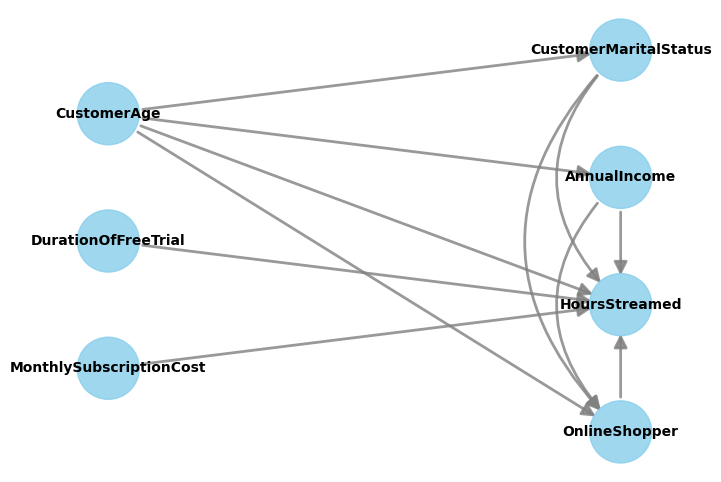

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(E[HoursStreamed|CustomerMaritalStatus,AnnualIncome,CustomerAg
d[OnlineShopper]                                                              

   
e])
   
Estimand assumption 1, Unconfoundedness: If U→{OnlineShopper} and U→HoursStreamed then P(HoursStreamed|OnlineShopper,CustomerMaritalStatus,AnnualIncome,CustomerAge,U) = P(HoursStreamed|OnlineShopper,CustomerMaritalStatus,AnnualIncome,CustomerAge)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


BACKDOOR LINEAR REGRESSION RESULTS
Results with placebo treatment refuter:
Refute: Use a Placebo Treatment
Estimated effect:0.3596302919676333
New effect:-0.07808176010819459
p value:0.45811041610020087

Results with data subset refuter:
Refute: Use a subset of data
Estimated effect:0.3596302919676333
New effect:0.4673591966524061
p value:0.4484679302692053



             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


BACKDOOR PROPENSITY SCORE MATCHING RESULTS
Results with placebo treatment refuter:
Refute: Use a Placebo Treatment
Estimated effect:15.787715517241379
New effect:-1.969935344827586
p value:0.24525213016181735

Results with data subset refuter:
Refute: Use a subset of data
Estimated effect:15.787715517241379
New effect:16.391509433962263
p value:0.14728793078078206



             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


BACKDOOR PROPENSITY SCORE WEIGHTING RESULTS
Results with placebo treatment refuter:
Refute: Use a Placebo Treatment
Estimated effect:0.7616610269645818
New effect:-0.5470591418240733
p value:0.2839421140052104

Results with data subset refuter:
Refute: Use a subset of data
Estimated effect:0.7616610269645818
New effect:0.7433150725112633
p value:0.48321784608282625



In [ ]:
#Create a causal diagram
causal_graph = """
digraph {

CustomerAge -> CustomerMaritalStatus;
CustomerAge -> AnnualIncome;
CustomerAge -> HoursStreamed;
CustomerAge -> OnlineShopper;
CustomerMaritalStatus -> OnlineShopper;
CustomerMaritalStatus -> HoursStreamed;
AnnualIncome -> OnlineShopper;
AnnualIncome -> HoursStreamed
OnlineShopper -> HoursStreamed;
DurationOfFreeTrial -> HoursStreamed;
MonthlySubscriptionCost -> HoursStreamed

}
"""

#Build the model in DoWhy
model = CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='OnlineShopper',
        outcome='HoursStreamed')
model.view_model()

#Identify the causal effect. Pearl's calculations in the background
estimands = model.identify_effect()
print(estimands)

#----------------------------------------------BACKDOOR LINEAR REGRESSION----------------------------------------------


causal_estimate_reg = model.estimate_effect(estimands,
                                            method_name="backdoor.linear_regression",
                                            test_significance=True)

placebo_refute_blr = model.refute_estimate(estimands, causal_estimate_reg,
                                           method_name="placebo_treatment_refuter", num_simulations=20)

subset_refute_blr = model.refute_estimate(estimands,causal_estimate_reg,
                                            method_name = "data_subset_refuter", num_simulations=20)

print("BACKDOOR LINEAR REGRESSION RESULTS")
print("Results with placebo treatment refuter:")
print(placebo_refute_blr)

print("Results with data subset refuter:")
print(subset_refute_blr)


#---------------------------------------------------------------------------------------------------------
#----------------------------------------------BACKDOOR PROPENSITY SCORE MATCHING----------------------------------------------
causal_estimate_match = model.estimate_effect(estimands,
                                              method_name="backdoor.propensity_score_matching",
                                              #target_units="ate",
                                              test_significance=True)

placebo_refute_bpsm = model.refute_estimate(estimands,causal_estimate_match,
                                              method_name = "placebo_treatment_refuter", num_simulations=20)

subset_refute_bpsm = model.refute_estimate(estimands,causal_estimate_match,
                                              method_name = "data_subset_refuter", num_simulations=20)


print("BACKDOOR PROPENSITY SCORE MATCHING RESULTS")
print("Results with placebo treatment refuter:")
print(placebo_refute_bpsm)

print("Results with data subset refuter:")
print(subset_refute_bpsm)

#---------------------------------------------------------------------------------------------------------
#----------------------------------------------BACKDOOR PROPENSITY SCORE WEIGHTING----------------------------------------------
causal_estimate_ipw = model.estimate_effect(estimands,
                                            method_name="backdoor.propensity_score_weighting",
                                            #target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"},
                                            test_significance=True)

placebo_refute_bpsw = model.refute_estimate(estimands,causal_estimate_ipw,
                                              method_name = "placebo_treatment_refuter", num_simulations=20)

subset_refute_bpsw = model.refute_estimate(estimands,causal_estimate_ipw,
                                              method_name = "data_subset_refuter", num_simulations=20)

print("BACKDOOR PROPENSITY SCORE WEIGHTING RESULTS")
print("Results with placebo treatment refuter:")
print(placebo_refute_bpsw)

print("Results with data subset refuter:")
print(subset_refute_bpsw)

# **Q2 Part 1: Does Subscription Type affect Hours Streamed (controlling for Annual Income)?**

In [ ]:
x = df[['MonthlySubscriptionCost', 'AnnualIncome']]
y = df['HoursStreamed']
x = sm.add_constant(x)
initial_reg = sm.OLS(y,x).fit()
print(initial_reg.summary())

                            OLS Regression Results                            
Dep. Variable:          HoursStreamed   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2695
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.764
Time:                        05:16:41   Log-Likelihood:                -3803.6
No. Observations:                 928   AIC:                             7613.
Df Residuals:                     925   BIC:                             7628.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# **Q2 Part 2: Does Subscription Type affect Hours Streamed (blocking by Annual Income)?**

In [ ]:
# To find the median of Annual Income for blocking
median_income = df['AnnualIncome'].median()
print("Median of Annual Income:", median_income)

Median of Annual Income: 131.0


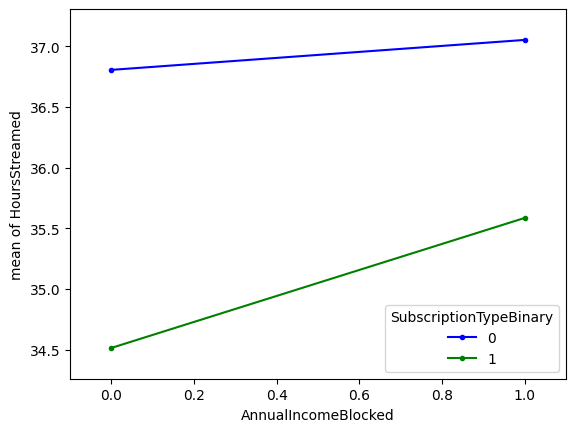

In [ ]:
# AnnualIncomeBlocked represents the split by median income, rounding down to 130 simplicity
fig = interaction_plot(trace=df['SubscriptionTypeBinary'], x=df['AnnualIncomeBlocked'],
                       response=df['HoursStreamed'],
                       colors=['blue', 'green',])
plt.show()

In [ ]:
# Regression Model 1 (Both Predictors & Interaction Term)
model = ols('HoursStreamed ~ C(SubscriptionTypeBinary) + C(AnnualIncomeBlocked) + C(SubscriptionTypeBinary):C(AnnualIncomeBlocked)', data=df).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(SubscriptionTypeBinary),1.0,716.316540,716.316540,3.366424,0.066859
C(AnnualIncomeBlocked),1.0,61.956835,61.956835,0.291174,0.589599
C(SubscriptionTypeBinary):C(AnnualIncomeBlocked),1.0,34.718179,34.718179,0.163163,0.686355
Residual,924.0,196611.129136,212.782607,NaN,NaN


In [ ]:
# Regression Model 2 (Only SubscriptionTypeBinary)
model2 = ols('HoursStreamed ~ C(SubscriptionTypeBinary)', data=df).fit()
sm.stats.anova_lm(model2)

,df,sum_sq,mean_sq,F,PR(>F)
C(SubscriptionTypeBinary),1.0,716.31654,716.316540,3.372053,0.066632
Residual,926.0,196707.80415,212.427434,NaN,NaN


# **Q3: Does Marital Status affect User Satisfacton Score (controlling for Age and Gender)**

In [ ]:
x2 = df.iloc[:,np.r_[5,7,12:15,15]]
y2 = df['UserSatisfactionScore']
x2 = sm.add_constant(x2)
initial_reg2 = sm.OLS(y2,x2).fit()
print(initial_reg2.summary())

                              OLS Regression Results                             
Dep. Variable:     UserSatisfactionScore   R-squared:                       0.005
Model:                               OLS   Adj. R-squared:                 -0.001
Method:                    Least Squares   F-statistic:                    0.8035
Date:                   Fri, 15 Dec 2023   Prob (F-statistic):              0.567
Time:                           05:24:18   Log-Likelihood:                -828.33
No. Observations:                    928   AIC:                             1671.
Df Residuals:                        921   BIC:                             1704.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

#  **Q4: Does Subscription Type (Advertisements and No Advertisements) affect Subscription Rate?**

In [ ]:
# Splitting data by Ad-Present and Ad-Absent Plans
no_ads = df[df['SubscriptionTypeBinary'] == 1]
ads = df[df['SubscriptionTypeBinary'] == 0]

# Calculate conversions and sample sizes for each group
conversions_no_ads = no_ads['Subscribed'].sum()
nobs_no_ads = len(no_ads)
conversion_rate_no_ads = conversions_no_ads / nobs_no_ads

conversions_ads = ads['Subscribed'].sum()
nobs_ads = len(ads)
conversion_rate_ads = conversions_ads / nobs_ads

# Perform proportions z-test
z_score, p_value_ztest = proportions_ztest([conversions_no_ads, conversions_ads], [nobs_no_ads, nobs_ads])

# Create a contingency table for chi-squared test
cont_table = [[conversions_no_ads, (nobs_no_ads - conversions_no_ads)], [conversions_ads, (nobs_ads - conversions_ads)]]
chi2_stat, p_value_chi2, _, _ = chi2_contingency(cont_table)

# Print the results
print('Conversion rate of no ads trial period:', conversion_rate_no_ads)
print('Conversion rate of ads trial period:', conversion_rate_ads)
print('Proportions z-test p-value:', p_value_ztest)
print('Chi-squared test p-value:', p_value_chi2)

Conversion rate of no ads trial period: 0.6480263157894737
Conversion rate of ads trial period: 0.6522435897435898
Proportions z-test p-value: 0.8993468949095398
Chi-squared test p-value: 0.9576328717573851


# **Q5: Does Duration of Free Trial (Short and Long Trial Periods) affect Subscription Rate?**

In [ ]:
# Splitting data by shorter and longer trial periods
short_trial = df[df['DurationOfFreeTrial'] < 10]
long_trial = df[df['DurationOfFreeTrial'] >= 10]

# Calculate conversions and sample sizes for each group
conversions_short = short_trial['Subscribed'].sum()
nobs_short = len(short_trial)
conversion_rate_short = conversions_short / nobs_short

conversions_long = long_trial['Subscribed'].sum()
nobs_long = len(long_trial)
conversion_rate_long = conversions_long / nobs_long

# Perform proportions z-test
z_score, p_value_ztest = proportions_ztest([conversions_short, conversions_long], [nobs_short, nobs_long])

# Create a contingency table for chi-squared test
cont_table = [[conversions_short, (nobs_short - conversions_short)], [conversions_long, (nobs_long - conversions_long)]]
chi2_stat, p_value_chi2, _, _ = chi2_contingency(cont_table)

# Print the results
print('Subscription renewal rate of short trial (< 10 days) period:', round(conversion_rate_short, 2))
print('Subscription renewal rate of long trial (>= 10 days) period:', round(conversion_rate_long, 2))
print('Proportions z-test p-value:', p_value_ztest)
print('Chi-squared test p-value:', p_value_chi2)

Subscription renewal rate of short trial (< 10 days) period: 0.53
Subscription renewal rate of long trial (>= 10 days) period: 0.73
Proportions z-test p-value: 1.1703261822899281e-09
Chi-squared test p-value: 1.8153283099004142e-09
